In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

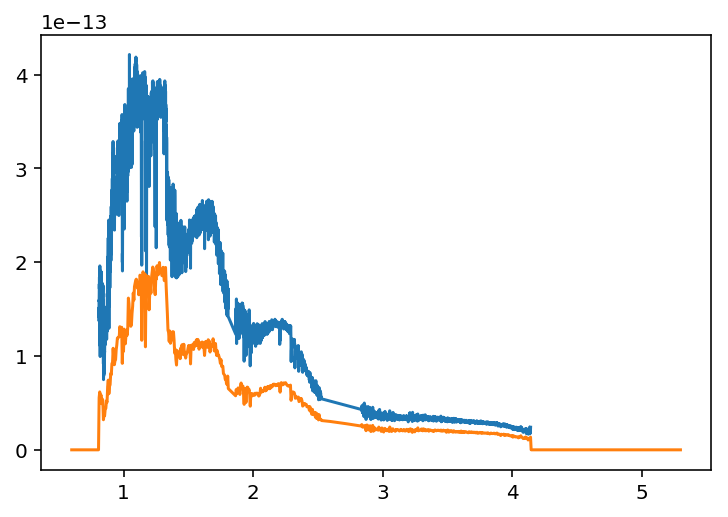

In [15]:
from libra import throughput, IRTFTemplate, quantum_efficiency

wavelengths = np.linspace(0.6, 5.3, 1000) * u.um

m8v = IRTFTemplate('M8V')
m2v = IRTFTemplate('M2V')
k2v = IRTFTemplate('K2V')

trans = throughput(wavelengths)
qe = quantum_efficiency(wavelengths)

plt.plot(m8v.wavelength, m8v.flux)
plt.plot(wavelengths, trans*m8v.interp_flux(wavelengths))

In [3]:
m8v.header['J']

gain = 1  #  e- / ADU

In [4]:
from astropy.constants import h, c

In [5]:
dlam = np.median(np.diff(m8v.wavelength))
aperture = 0.5 * u.m**2
exp_time = 1000 * u.s
(m8v.flux * m8v.wavelength / h / c * aperture * dlam * exp_time).decompose()

<Quantity [ 114623.53125  , 118159.78125  , 120958.625    ,...,
             81201.484375 ,  88277.7890625, 102154.4921875]>

In [6]:
from libra import magnitudes

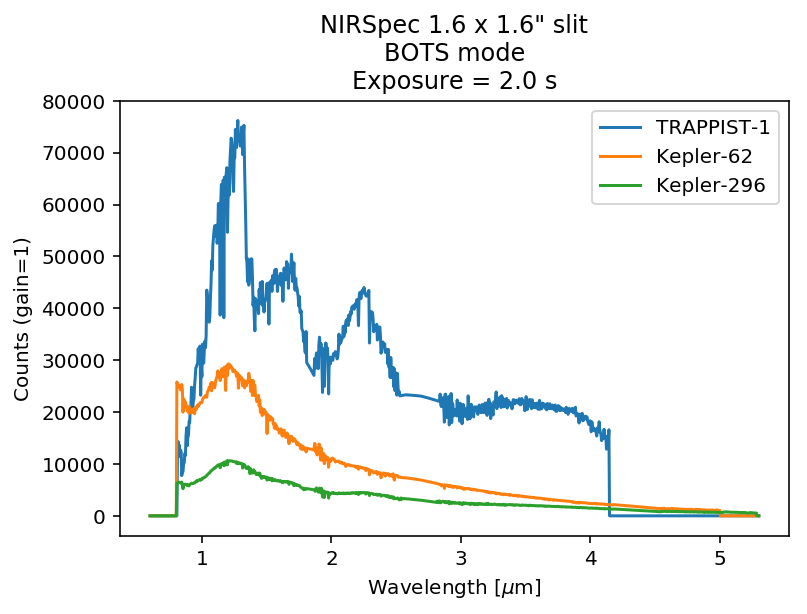

In [23]:
exp_time = 2*u.s
trappist_counts = m8v.n_photons(wavelengths, exp_time, J=magnitudes['TRAPPIST-1']['J'])
k62_counts = k2v.n_photons(wavelengths, exp_time, J=magnitudes['Kepler-62']['J'])
k296_counts = m2v.n_photons(wavelengths, exp_time, J=magnitudes['Kepler-296']['J'])

def observe(counts):
    return counts * trans * qe

plt.plot(wavelengths, observe(trappist_counts), label='TRAPPIST-1')
plt.plot(wavelengths, observe(k62_counts), label='Kepler-62')
plt.plot(wavelengths, observe(k296_counts), label='Kepler-296')

plt.title('NIRSpec 1.6 x 1.6" slit\nBOTS mode\nExposure = {0}'.format(exp_time))
plt.ylabel('Counts (gain=1)')
plt.xlabel('Wavelength [$\mu$m]')
plt.legend()
plt.savefig('saturation.pdf', bbox_inches='tight')